In [35]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
import networkx as nx
from scipy.spatial import cKDTree
import random

# Constants
D_MAX = 110           # Maximum distance for co-location (meters)
P_INF = 0.1           # Infection probability
TIME_WINDOW = 3600    # Time window for co-location (seconds)
INITIAL_INFECTED = 0.01  # Initial fraction of infected nodes
SAMPLING_PROPORTIONS = [0.025, 0.05, 0.1, 0.2]  # Sampling proportions


In [174]:
# STEP 1: Load the Gowalla dataset
file_path = 'loc-gowalla_totalCheckins.txt/Gowalla_totalCheckins.txt'  # Replace with your dataset path

# Define column names based on Gowalla dataset format
columns = ['user_id', 'timestamp', 'latitude', 'longitude', 'location_id']

# Load the dataset
gowalla_data = pd.read_csv(file_path, sep='\t', names=columns, parse_dates=['timestamp'])
print("Dataset Loaded Successfully!")

# Filter the dataset to a specific 20-day period and 20,000 users
start_date = pd.Timestamp('2010-10-1 00:00:00+00:00')
end_date = start_date + pd.DateOffset(days=20)
period_data = gowalla_data[(gowalla_data['timestamp'] >= start_date) & (gowalla_data['timestamp'] <= end_date)]
print("Dataset period filtered Successfully!")

# Identify the top 20,000 unique user_id
top_user_ids = period_data['user_id'].value_counts().index[:20000]
period_data = period_data[period_data['user_id'].isin(top_user_ids)]

# Filter invalid latitudes and longitudes
gowalla_data = period_data.loc[(period_data['latitude'] >= -90) & (period_data['latitude'] <= 90) &
                           (period_data['longitude'] >= -180) & (period_data['longitude'] <= 180)]

final_data_size = len(gowalla_data)
unique_user_ids = gowalla_data['user_id'].nunique()
print(f"Final dataset size: {final_data_size} rows")
print(f"Number of unique user_id in the final dataset: {unique_user_ids}")

Dataset Loaded Successfully!
Dataset period filtered Successfully!
Final dataset size: 631796 rows
Number of unique user_id in the final dataset: 20000


In [175]:
# STEP 2: Build Contact Networks with Edge Weights
def build_contact_network_optimized(data, d_max=D_MAX, time_window=TIME_WINDOW):
    """
    Build a collection of contact networks using spatial and temporal optimizations.
    """
    G = {}  # Dictionary to store contact networks for each time window

    # Sort data by timestamp for efficient grouping
    data = data.sort_values(by='timestamp')

    # Group data into time windows
    min_time = data['timestamp'].min()
    data['time_bucket'] = ((data['timestamp'] - min_time).dt.total_seconds() // time_window).astype(int)
    grouped = data.groupby('time_bucket')

    for time_bucket, group in grouped:
        coords = group[['latitude', 'longitude']].values
        tree = cKDTree(coords)

        # Create a new network for this time window
        G[time_bucket] = nx.Graph()
        pairs = tree.query_pairs(d_max / 1000)
        for i, j in pairs:
            user1, user2 = group['user_id'].values[i], group['user_id'].values[j]
            G[time_bucket].add_edge(user1, user2, weight=P_INF)  # Add edge with initial weight

    return G

contact_graph = build_contact_network_optimized(gowalla_data)
print("Contact Graph Generated Successfully!")

# Update Edge Weights
def change_edge_weights(contact_graph, new_weight):
    """
    Change the weight of all edges in the contact graph to a new specified weight.
    """
    for time_bucket, graph in contact_graph.items():
        for u, v, data in graph.edges(data=True):
            data['weight'] = new_weight

change_edge_weights(contact_graph, P_INF)
print("Edge weights in the contact graph have been updated to", P_INF)

Contact Graph Generated Successfully!
Edge weights in the contact graph have been updated to 0.1


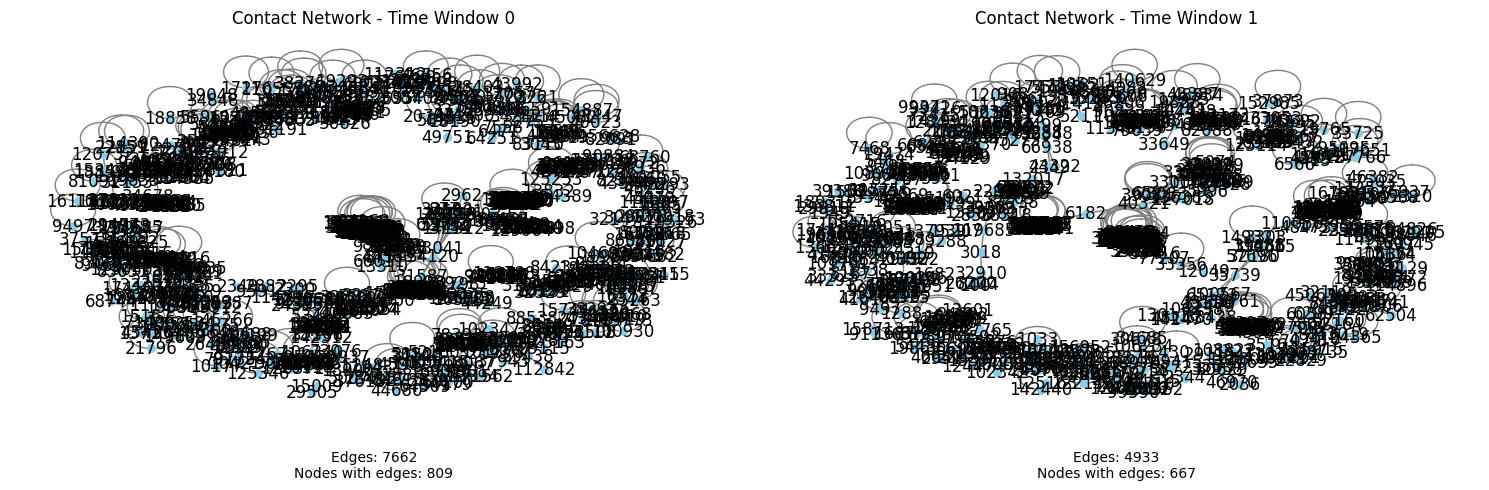

In [37]:
def plot_graph_with_edges_info(contact_graph, num_graphs=10, graphs_per_row=2):
    num_rows = num_graphs // graphs_per_row + (num_graphs % graphs_per_row > 0)
    fig, axs = plt.subplots(num_rows, graphs_per_row, figsize=(15, 5 * num_rows))

    for i, (time_bucket, G_network) in enumerate(contact_graph.items()):
        if i >= num_graphs:
            break

        row = i // graphs_per_row
        col = i % graphs_per_row

        edges = list(G_network.edges())
        nodes_with_edges = set([n for e in edges for n in e])

        G_subgraph = G_network.subgraph(nodes_with_edges)

        ax = axs[row, col] if num_rows > 1 else axs[col]
        ax.set_title(f"Contact Network - Time Window {time_bucket}")

        nx.draw(G_subgraph, with_labels=True, node_color='skyblue', node_size=30, edge_color='gray', ax=ax)

        num_edges = len(edges)
        num_nodes_with_edges = len(nodes_with_edges)
        ax.text(0.5, -0.1, f"Edges: {num_edges}\nNodes with edges: {num_nodes_with_edges}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    for i in range(num_graphs, num_rows*graphs_per_row):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()

# Assuming contact_graph is a dictionary containing contact networks
plot_graph_with_edges_info(contact_graph, num_graphs=2, graphs_per_row=2)

In [176]:
# Set the initial values
Days_to_IS = pd.to_timedelta(5, unit='D')
Days_of_Spread = pd.to_timedelta(7, unit='D')

# Calculate Days_to_R by adding Days_of_Spread and Days_to_IS
Days_to_R = Days_of_Spread + Days_to_IS
NUM_Time_Bucket_Spread = int(Days_of_Spread.total_seconds() // TIME_WINDOW)
all_nodes = set(gowalla_data['user_id'])

In [177]:
print(NUM_Time_Bucket_Spread)

168


In [178]:
def monte_carlo_simulation(contact_graph, all_nodes, initial_infected, P_INF, r, sample_rate, num_time_bucket_spread):
    total_infections = 0

    node_list = set(np.random.choice(list(all_nodes), int(len(all_nodes) * sample_rate), replace=False))
    for _ in range(r):
        infected = set(np.random.choice(list(node_list), int(len(node_list) * initial_infected), replace=False))
        susceptible = node_list - infected
        sum_infected = len(infected)

        for t in range(num_time_bucket_spread):
            if t not in contact_graph:
                continue
            
            new_infected = set()
            for u in susceptible:
                if u not in contact_graph[t].nodes:
                    continue
                neighbors = set(contact_graph[t].neighbors(u))
                if any(np.random.rand() < P_INF for v in neighbors if v in infected):
                    new_infected.add(u)
            
            if not new_infected:
                break
            infected |= new_infected
            susceptible -= new_infected
            sum_infected += len(new_infected)
        
        total_infections += sum_infected / r
    
    return (total_infections) / sample_rate
    

# Set up your contact graph, all_nodes set, and other parameters
# Call the function with the required parameters

sampling_ground_expected = monte_carlo_simulation(contact_graph, all_nodes, INITIAL_INFECTED, P_INF, 10, 1, NUM_Time_Bucket_Spread)
print("ground truth number of infections average 10 runs:", sampling_ground_expected)

ground truth number of infections average 10 runs: 5281.299999999999


In [179]:
SAMPLING_PROPORTIONS = [0.025, 0.05, 0.1, 0.2]  # Sampling proportions
sampling_expected_infections = []  # Initialize list to store results
scaling_bias = []

for sub_sample_rate in range(len(SAMPLING_PROPORTIONS)):
    sampling_expected_infections.append(monte_carlo_simulation(contact_graph, all_nodes, INITIAL_INFECTED, P_INF, 1000, SAMPLING_PROPORTIONS[sub_sample_rate], NUM_Time_Bucket_Spread))
    scaling_bias.append(sampling_ground_expected - sampling_expected_infections[sub_sample_rate])
    print("Sample rate", SAMPLING_PROPORTIONS[sub_sample_rate], "Number of infections average over 100 runs:", sampling_expected_infections[sub_sample_rate])

Sample rate 0.025 Number of infections average over 100 runs: 201.35999999999663
Sample rate 0.05 Number of infections average over 100 runs: 201.1799999999967
Sample rate 0.1 Number of infections average over 100 runs: 201.51999999999703
Sample rate 0.2 Number of infections average over 100 runs: 201.54999999999708


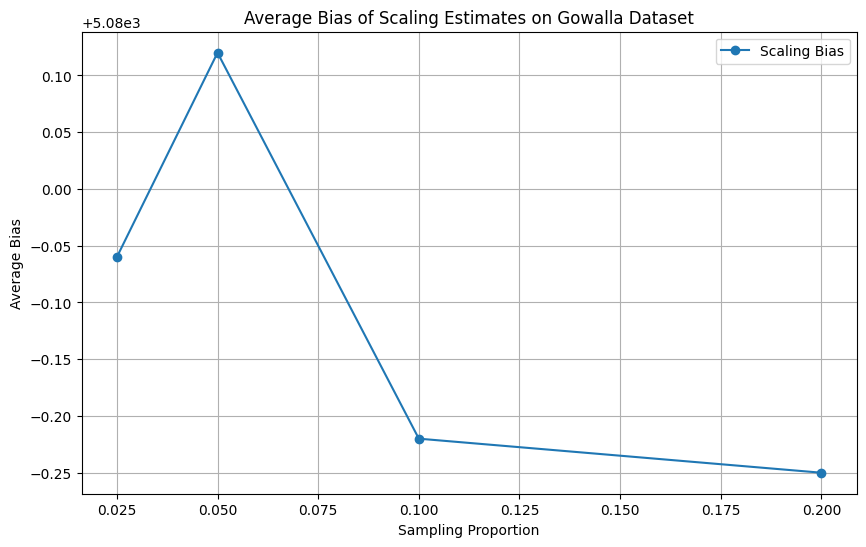

In [180]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(SAMPLING_PROPORTIONS, scaling_bias, marker='o', label='Scaling Bias')
plt.xlabel('Sampling Proportion')
plt.ylabel('Average Bias')
plt.title('Average Bias of Scaling Estimates on Gowalla Dataset')
plt.legend()
plt.grid()
plt.show()

In [181]:
def poll_spreader_simulation(contact_graph, all_nodes, initial_infected, P_INF, r, sample_rate, num_time_bucket_spread):
    total_edge = 0
    total_edge_weight = 0
    node_list = set(np.random.choice(list(all_nodes), int(len(all_nodes) * sample_rate), replace=False))
    
    for _ in range(r):
        overall_contact_graph = nx.Graph()
        int_infected = set(np.random.choice(list(node_list), int(len(node_list) * initial_infected), replace=False))
        infected = int_infected
        susceptible = node_list - infected
        susceptible_int = susceptible
        
        for t in range(num_time_bucket_spread):
            if t not in contact_graph:
                continue
            
            for u in susceptible_int:
                if u not in contact_graph[t].nodes:
                    continue
                neighbors = set(contact_graph[t].neighbors(u))
                for v in neighbors:
                    if v in int_infected:
                        overall_contact_graph.add_edge(u, v)

        # Calculate the total number of edges that satisfy the condition
        total_edge += overall_contact_graph.number_of_edges() / r

    total_edge_weight = (1/(sample_rate**2)) * total_edge * P_INF
    p_at_least_one_edge = 1 - (( 1 - (1/len(susceptible_int)))**total_edge_weight)
    p_t_u = initial_infected + (1-initial_infected)*p_at_least_one_edge
    total_infected = p_t_u * len(node_list)

    
    return total_infected
poll_spreader_ground_expected = poll_spreader_simulation(contact_graph, all_nodes, INITIAL_INFECTED, P_INF, 10, 1, NUM_Time_Bucket_Spread)
print("p_t_u:", poll_spreader_ground_expected)

p_t_u: 1192.1739263582297


In [182]:
poll_spreader_expected_infections = []  # Initialize list to store results
poll_spreader_bias = []

for sub_sample_rate in range(len(SAMPLING_PROPORTIONS)):
    poll_spreader_expected_infections.append(poll_spreader_simulation(contact_graph, all_nodes, INITIAL_INFECTED, P_INF, 10, SAMPLING_PROPORTIONS[sub_sample_rate], NUM_Time_Bucket_Spread))
    poll_spreader_bias.append(poll_spreader_ground_expected - poll_spreader_expected_infections[sub_sample_rate])
    print("Sample rate", SAMPLING_PROPORTIONS[sub_sample_rate], "Number of infections average over 10 runs:", poll_spreader_expected_infections[sub_sample_rate])

Sample rate 0.025 Number of infections average over 10 runs: 457.6695206090956
Sample rate 0.05 Number of infections average over 10 runs: 588.2179699861247
Sample rate 0.1 Number of infections average over 10 runs: 816.6843452532121
Sample rate 0.2 Number of infections average over 10 runs: 988.7785182351884


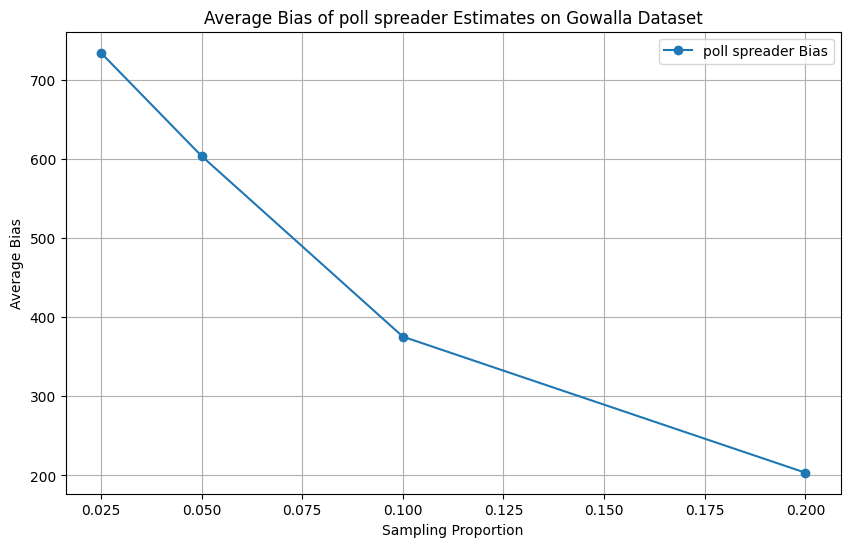

In [184]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(SAMPLING_PROPORTIONS, poll_spreader_bias, marker='o', label='poll spreader Bias')
plt.xlabel('Sampling Proportion')
plt.ylabel('Average Bias')
plt.title('Average Bias of poll spreader Estimates on Gowalla Dataset')
plt.legend()
plt.grid()
plt.show()

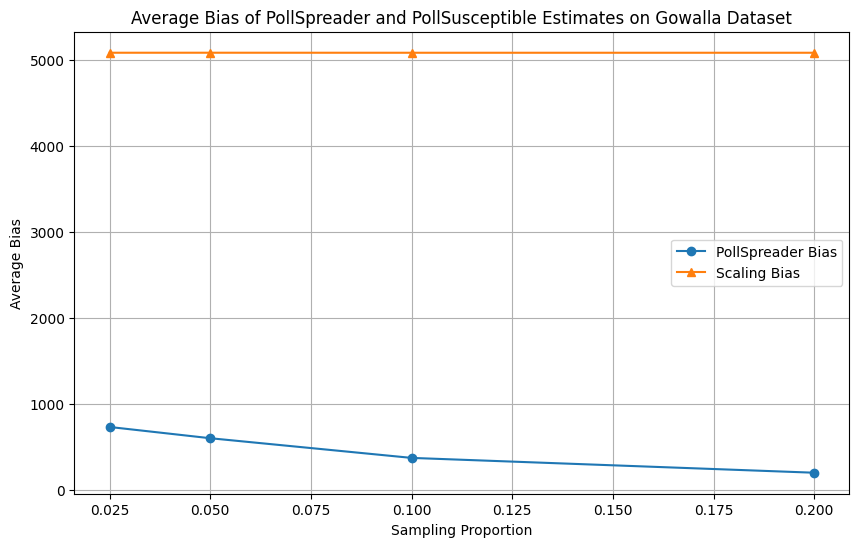

In [183]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(SAMPLING_PROPORTIONS, poll_spreader_bias, marker='o', label='PollSpreader Bias')
plt.plot(SAMPLING_PROPORTIONS, scaling_bias, marker='^', label='Scaling Bias')
plt.xlabel('Sampling Proportion')
plt.ylabel('Average Bias')
plt.title('Average Bias of PollSpreader and PollSusceptible Estimates on Gowalla Dataset')
plt.legend()
plt.grid()
plt.show()